# Machine Learning & Statistics Project

# Introduction

We have been tasked with creating a web service that uses machine learning to make predictions based on the data set provided on power production taken from Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. We must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. 

Keras could be used to manage the data. Takes large number of float inputs and provides output

# Introduction

# Wind Power Description



# Explore the data

First we will import the required libraries and start to explore the data to get a feel for what we're dealing with.

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import sklearn  
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

#matplotlib inline
rcParams['figure.figsize']=5, 4

# Import the csv file containing the information
df = pd.read_csv('powerproduction.txt')

# Check first 10 rows to ensure we're getting correct data in as first 5 columns power outputt displayed as 0
print(f'{df.head(11)}\n')
print(f'{df.tail(15)}\n')

# Display dataframes information
print(f'{df.info()}\n')
print(f'{df.describe()}\n')
print(f'{df.shape}\n')

print(f'{df.isnull().sum()}\n')
print(f'{df.isna().sum()}')

    speed  power
0   0.000  0.000
1   0.125  0.000
2   0.150  0.000
3   0.225  0.000
4   0.275  0.000
5   0.325  4.331
6   0.400  5.186
7   0.450  3.826
8   0.501  1.048
9   0.526  5.553
10  0.551  6.498

      speed    power
485  24.249  103.700
486  24.299   93.694
487  24.349   93.078
488  24.374   98.223
489  24.399   95.117
490  24.499    0.000
491  24.525    0.000
492  24.575    0.000
493  24.650    0.000
494  24.750    0.000
495  24.775    0.000
496  24.850    0.000
497  24.875    0.000
498  24.950    0.000
499  25.000    0.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6

From the above we can see that the information received is 2 colmuns of 500 rows populated by floats. The speed range is 0-25 and the power range  is 0-100. No units are given in this table but for the purpose of this project it will be assumed the speed is measured in m/s and the power is in % of design output.

We can see that at the minimum and maximum speed values there is a value of 0 which is showing us a minimum wind speed required to start  the power generation and a high point cut off switch. We will need to visualise the data to check for anymore 0 values scattered in the data as this could potentially throw off our calculations.

The data is sorted sequentially by speed power with the power generation generally increasing with it within a certain range. This shows an almost linear relationship between the two variables.

There appears to be no missing information in the data as shown by our `df.isnull().sum()` and `df.isna().sum()` check. This data will need to be cleaned before it will be useable. Too determine if there are any other  anomolies we'll plot some graphs to give a better visual representation off the data.

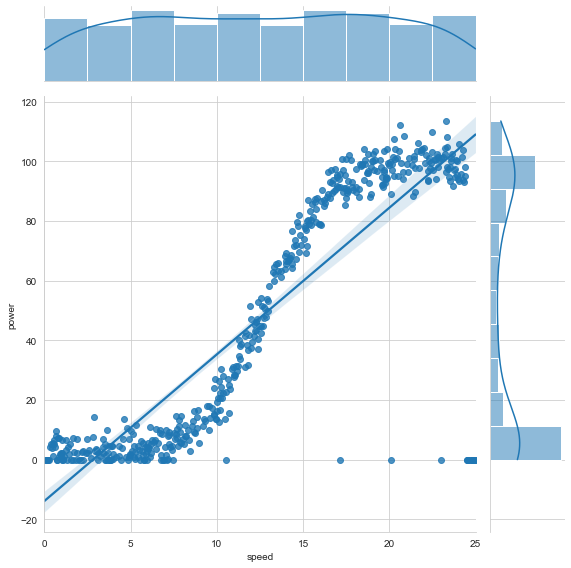

In [133]:
# Visualise dataset
sns.jointplot(data=df, x="speed", y="power",kind="reg", height=8)
#sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

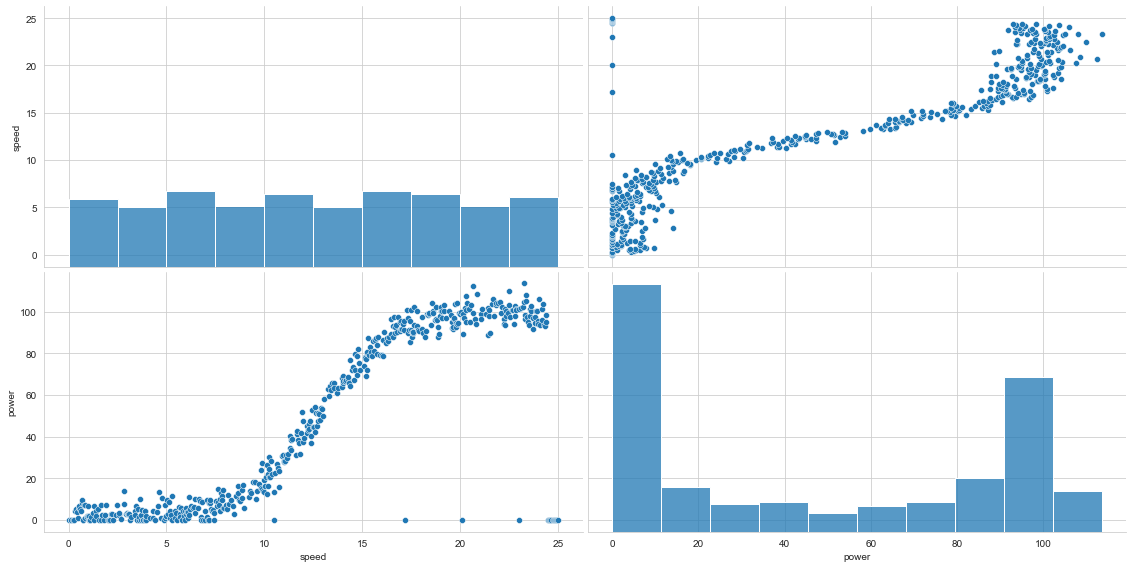

In [134]:
sns.pairplot(df, height=4, aspect=2);

The above shows us  that it is not a typical linear relationship between speed  and power. It appears to follow a polynomial pattern. It shows that while the wind speed is below 10 m/s th epower generation remains low. From 10 to around 18 m/s there is a much faster growth of power generation before peaking out around the 100% mark at about 18  m/s wind speed where it remains until the wind speed reaches 24.5 m/s when an automatic cut off takes effect dropping power generation to 0.

We can also see that there are several 0 values taken for the power generation at various speeds. This could be due to a malfunction or maintenance period on the turbine itself so these will need to be removed before moving forward to determine an accurate algorithm. 

##  Clean Data

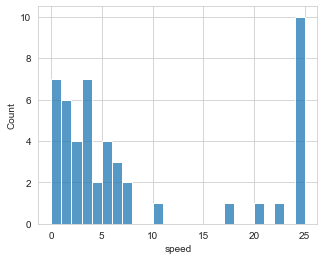

In [135]:
#  Check were majority of readings for 0 power generation values are located. 
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

It appears the vast majority of the 0 readings are at both the low and high ends. From our inital look at the head and tail of the data we can see that the power generation doesn't start until 0.325 m/s wind speed and cuts out from 24.499 m/s wind speed. We will now  use this infomration to remove all values of 0 above the 0.325 value assuming that this is due to a malfunction or a maintenance period and therefore should not have any influence on our alogrithm generation as it is an independent event that has no bearing on the data. The high end cut off also needs to be removed to ensure accuracy in our prerdictions.

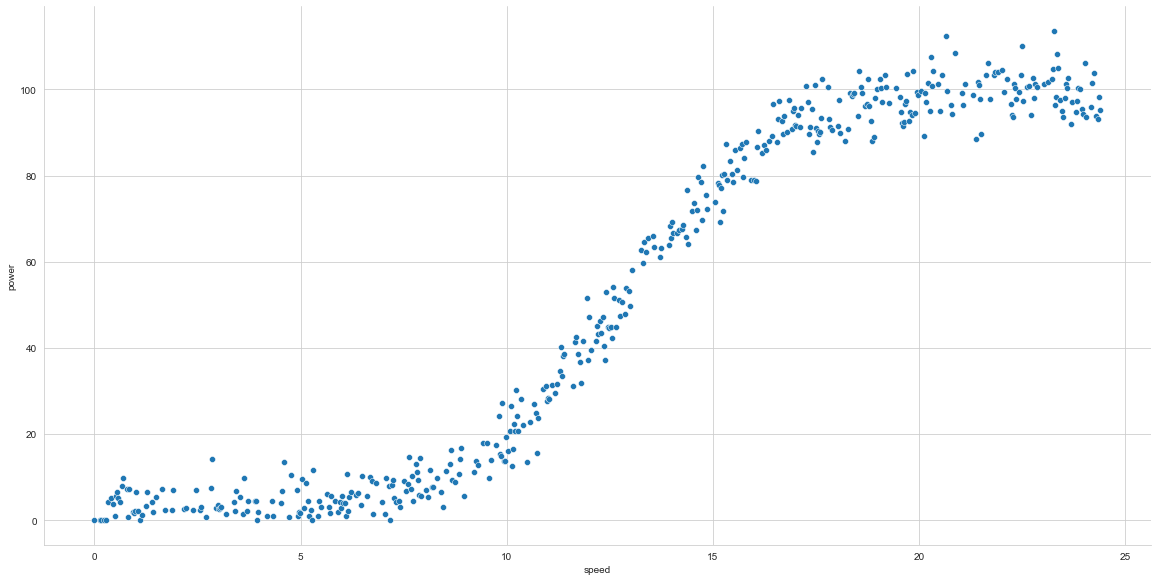

In [136]:
# https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
df = df.drop(df[(df.speed >= 0.325) & (df.power == 0.0)].index)

sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

(456, 2)

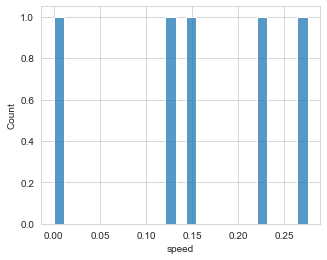

In [137]:
# Check dataframe for locations of remaining 0 values
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

df.shape

We can see form  the above that all 0 values between 0.325 m/s and 24.499 m/s have been removed as intended. This brings our dataframe size from 500 rows to 466 rows for a total of 34 rows removed. We can now work with this dataframe to begin to determine the correct algorithm.

## Linear Regression



Looking at the graphs provided we will explore the possibility of fitting a linear regression line onn to the graph. I believe this will not lead to an accurate predictor model but afterwards we can look at polynomial lines to make the fit more suitable.

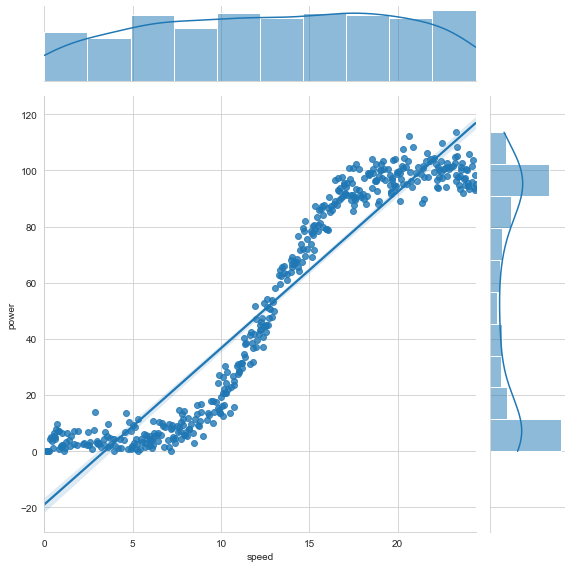

In [138]:
sns.jointplot(data=df, x="speed", y="power",kind="reg", height= 8)

In [139]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

x = df.power.to_numpy()
y = df.speed.to_numpy()

results = sm.OLS(x, y).fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              7639.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):                   1.49e-286
Time:                        17:32:08   Log-Likelihood:                         -1904.7
No. Observations:                 456   AIC:                                      3811.
Df Residuals:                     455   BIC:                                      3815.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the plot above we can see that a straight line through

In [149]:
y = df.power.to_numpy() 
x = df.speed.to_numpy().reshape(-1, 1) # reshape called as array is required to be two-dimensional
print(x)

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('slope:', model.coef_)


[[ 0.   ]
 [ 0.125]
 [ 0.15 ]
 [ 0.225]
 [ 0.275]
 [ 0.325]
 [ 0.4  ]
 [ 0.45 ]
 [ 0.501]
 [ 0.526]
 [ 0.551]
 [ 0.576]
 [ 0.626]
 [ 0.676]
 [ 0.701]
 [ 0.801]
 [ 0.826]
 [ 0.851]
 [ 0.926]
 [ 0.951]
 [ 0.976]
 [ 1.001]
 [ 1.051]
 [ 1.101]
 [ 1.151]
 [ 1.251]
 [ 1.276]
 [ 1.401]
 [ 1.426]
 [ 1.502]
 [ 1.652]
 [ 1.702]
 [ 1.877]
 [ 1.902]
 [ 2.177]
 [ 2.227]
 [ 2.402]
 [ 2.477]
 [ 2.553]
 [ 2.578]
 [ 2.703]
 [ 2.828]
 [ 2.853]
 [ 2.953]
 [ 3.003]
 [ 3.028]
 [ 3.053]
 [ 3.078]
 [ 3.203]
 [ 3.378]
 [ 3.403]
 [ 3.428]
 [ 3.529]
 [ 3.604]
 [ 3.629]
 [ 3.704]
 [ 3.729]
 [ 3.904]
 [ 3.929]
 [ 3.954]
 [ 3.979]
 [ 4.179]
 [ 4.304]
 [ 4.329]
 [ 4.53 ]
 [ 4.555]
 [ 4.605]
 [ 4.73 ]
 [ 4.78 ]
 [ 4.905]
 [ 4.93 ]
 [ 4.955]
 [ 4.98 ]
 [ 5.03 ]
 [ 5.08 ]
 [ 5.13 ]
 [ 5.18 ]
 [ 5.205]
 [ 5.255]
 [ 5.28 ]
 [ 5.305]
 [ 5.43 ]
 [ 5.455]
 [ 5.506]
 [ 5.631]
 [ 5.681]
 [ 5.706]
 [ 5.731]
 [ 5.831]
 [ 5.906]
 [ 5.956]
 [ 5.981]
 [ 6.006]
 [ 6.031]
 [ 6.081]
 [ 6.106]
 [ 6.131]
 [ 6.156]
 [ 6.181]
 [ 6.231]


In [155]:
test=[[21.396]]

y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

predicted response:
[-1.89199060e+01 -1.82244501e+01 -1.80853589e+01 -1.76680854e+01
 -1.73899030e+01 -1.71117207e+01 -1.66944471e+01 -1.64162648e+01
 -1.61325188e+01 -1.59934276e+01 -1.58543364e+01 -1.57152452e+01
 -1.54370628e+01 -1.51588805e+01 -1.50197893e+01 -1.44634246e+01
 -1.43243334e+01 -1.41852422e+01 -1.37679687e+01 -1.36288775e+01
 -1.34897863e+01 -1.33506951e+01 -1.30725128e+01 -1.27943304e+01
 -1.25161480e+01 -1.19597833e+01 -1.18206921e+01 -1.11252362e+01
 -1.09861450e+01 -1.05633078e+01 -9.72876076e+00 -9.45057840e+00
 -8.47694013e+00 -8.33784895e+00 -6.80784595e+00 -6.52966359e+00
 -5.55602532e+00 -5.13875178e+00 -4.71591459e+00 -4.57682341e+00
 -3.88136750e+00 -3.18591159e+00 -3.04682041e+00 -2.49045569e+00
 -2.21227332e+00 -2.07318214e+00 -1.93409096e+00 -1.79499978e+00
 -1.09954387e+00 -1.25905603e-01  1.31855782e-02  1.52276760e-01
  7.14205132e-01  1.13147868e+00  1.27056986e+00  1.68784340e+00
  1.82693458e+00  2.80057285e+00  2.93966403e+00  3.07875521e+00
  3.2

## Sources

https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20check%20missing,null%20values%20in%20a%20series.

https://realpython.com/linear-regression-in-python/